In [7]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline
plt.rcParams['figure.figsize']=[15.0,12.0]
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.major.width']=2
plt.rcParams['xtick.minor.size']=4
plt.rcParams['xtick.minor.width']=2
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.major.width']=2
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.minor.width']=2
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['axes.labelsize'] =24
plt.rcParams['legend.fontsize']= 24
plt.rcParams['legend.framealpha'] = 0.95
plt.rcParams['legend.handlelength']=2.0
plt.rcParams['figure.facecolor']="w"
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [8]:
import sys, os
sys.path.append("/home/pat/terliuk/software/DARWIN/DecayFitter/")
from AnalyticCalculator import AnalyticCalculator
from BinnedFitter import BinnedFitter

In [9]:
bin_edges = np.linspace(2200, 2800, 25)
ltime = 10.
loader = AnalyticCalculator(bin_edges, 
                         livetime=ltime, 
                         )
fitter = BinnedFitter(loader =loader )


In [10]:
inject_values = {"AXe136": 0.0, 
                 "Scale208Tl" : 2.511,
                 "Norm214Bi" : 1.0,
                 "NormCont" : 1.0,
                 "ContSlope" : -1.2,
                 "Scale137Xe" : 1.42e-3, 
                 "T12_136Xe_2vbb" : 2.165
                }
histogram = fitter.getExpectation(**inject_values)
fitpriors_default = {"Scale208Tl" : [2.511, 0.082],  
                     "Norm214Bi"  : [1.0, 0.036],
                     "NormCont"   : [1.0, 0.036],
                     "ContSlope"  : [-1.2, 10.0],
                     "Scale137Xe" : [1.42e-3, 0.17e-3 ],
                     "T12_136Xe_2vbb" : [2.165, 0.063]
                        }
def_fvals = {"AXe136": [0.1, False], 
            "Scale208Tl" : [ 3.0, False],
            "Norm214Bi" : [1.1, False], 
            "NormCont" : [1.2, False],
            "ContSlope" : [-1., False],
            "Scale137Xe" : [1.5e-3, False],
            "T12_136Xe_2vbb" : [2.1, False]
           }

In [11]:
def get_settings_priors(case = "real"):
    cur_fvals = deepcopy(def_fvals)
    cur_priors = deepcopy(fitpriors_default)
    if case =="ideal":
        for key in cur_priors.keys():
            cur_priors[key] = [inject_values[key], 1e-8*inject_values[key] ]
    elif case =="real":
        pass
    elif "fix:" in case:
        variables = case.split("fix:")[-1]
        variables = variables.split(",")
        print("Fixing : ",  variables)
        for var in variables:
            cur_fvals[var] = [inject_values[var], True ]     
    elif "reducesigma:" in case: 
        reduceinfo = case.split("reducesigma:")[-1]
        reduceinfovars = reduceinfo.split(",")
        #print(reduceinfovars)
        for rline in reduceinfovars:
            tmpinf = rline.split("=")
            var = tmpinf[0]
            factor = float(tmpinf[1])
            print("%s reducing sigma by factor %0.2f"%(var, factor))
            cur_priors[var][1]=cur_priors[var][1]/factor
    else : 
        print("Error! Unknown confuration!")
        return None
    return cur_fvals, cur_priors

In [20]:
LLHs_null

{'real': array([nan, nan, nan, nan, nan, nan]),
 0: -2844.6597526953183,
 1: -2858.4690537235856,
 2: -2872.2783547520135,
 3: -2886.0876557801193,
 4: -2899.896956808388,
 5: -2913.7062578366535,
 'ideal': array([nan, nan, nan, nan, nan, nan])}

In [24]:
signal_strength  = np.linspace(0,1.0,101)

LLHs_global = {}
LLHs_null ={}

for case in ["real", "ideal"] : 
    print(case)
    
    LLHs_global[case] = np.nan*np.ones_like(signal_strength)
    LLHs_null[case] = np.nan*np.ones_like(signal_strength)
    cur_fsettings, cur_fpriors = get_settings_priors(case)
    cur_fsettings_null = deepcopy(cur_fsettings)
    cur_fsettings_null['AXe136'] = [0.0, True]
    for i in range(len(signal_strength)):
        print(signal_strength[i])
        cur_injvals = deepcopy(inject_values)
        cur_injvals['AXe136'] = signal_strength[i]
        cur_expectation = loader.getBinnedExpectation(**cur_injvals)
        cur_gl_fit = fitter.FitValue(histogram = cur_expectation, 
               fitvalues = cur_fsettings, 
               priors = cur_fpriors,
               ftol = 1e-3,
               verbosity = 0
               )
        LLHs_global[case][i] = cur_gl_fit['LLH']
        cur_null_fit = fitter.FitValue(histogram = cur_expectation, 
               fitvalues = cur_fsettings_null, 
               priors = cur_fpriors,
               ftol = 1e-3,
               verbosity = 0
               )
        LLHs_null[case][i] = cur_null_fit['LLH']
'''
globalfits = {}
nullfits = {}
for case in ["real", "ideal"] : 
    print(case)
    globalfits[case] = []
    nullfits[case] = []
    LLHs_global[case] = np.nan*np.ones_like(signal_strength)
    LLHs_null[case] = np.nan*np.ones_like(signal_strength)
    cur_fsettings, cur_fpriors = get_settings_priors(case)
    cur_fsettings_null = deepcopy(cur_fsettings)
    cur_fsettings_null['AXe136'] = [0.0, True]
    for i in range(len(signal_strength)):
        cur_injvals = deepcopy(inject_values)
        cur_injvals['AXe136'] = signal_strength[i]
        cur_expectation = loader.getBinnedExpectation(**cur_injvals)
        cur_gl_fit = fitter.FitValue(histogram = cur_expectation, 
               fitvalues = cur_fsettings, 
               priors = cur_fpriors,
               bounds=bounds, 
               errors = stepsizes, 
               ftol = 0.001,
               verbosity = 1
               )
        globalfits[case].append(cur_gl_fit)
        LLHs_global[case][i] = cur_gl_fit['LLH']
        cur_null_fit = fitter.FitValue(histogram = cur_expectation, 
               fitvalues = cur_fsettings_null, 
               priors = cur_fpriors,
               bounds=bounds, 
               errors = stepsizes, 
               ftol = 0.001,
               verbosity = 1
               )
        nullfits[case].append(cur_null_fit)
        LLHs_null[case][i] = cur_null_fit['LLH']
    pass'''

real
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0
ideal
0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.5

'\nglobalfits = {}\nnullfits = {}\nfor case in ["real", "ideal"] : \n    print(case)\n    globalfits[case] = []\n    nullfits[case] = []\n    LLHs_global[case] = np.nan*np.ones_like(signal_strength)\n    LLHs_null[case] = np.nan*np.ones_like(signal_strength)\n    cur_fsettings, cur_fpriors = get_settings_priors(case)\n    cur_fsettings_null = deepcopy(cur_fsettings)\n    cur_fsettings_null[\'AXe136\'] = [0.0, True]\n    for i in range(len(signal_strength)):\n        cur_injvals = deepcopy(inject_values)\n        cur_injvals[\'AXe136\'] = signal_strength[i]\n        cur_expectation = loader.getBinnedExpectation(**cur_injvals)\n        cur_gl_fit = fitter.FitValue(histogram = cur_expectation, \n               fitvalues = cur_fsettings, \n               priors = cur_fpriors,\n               bounds=bounds, \n               errors = stepsizes, \n               ftol = 0.001,\n               verbosity = 1\n               )\n        globalfits[case].append(cur_gl_fit)\n        LLHs_global[case

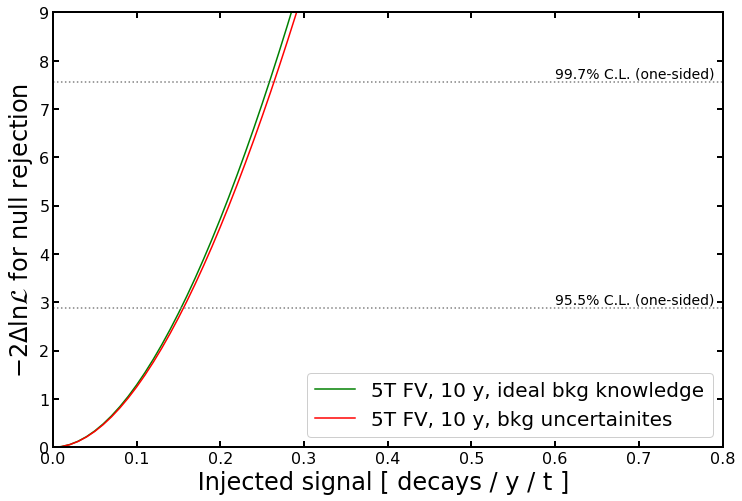

In [25]:
# And plotting the scan 
fig = plt.figure(figsize = (12,8))
ax= fig.add_subplot(111)

ax.plot(signal_strength, 2.0*(LLHs_null['ideal'] - LLHs_global['ideal']), c ="g", label = "5T FV, 10 y, ideal bkg knowledge" )
ax.plot(signal_strength, 2.0*(LLHs_null['real'] - LLHs_global['real']), c ="r" , label = "5T FV, 10 y, bkg uncertainites" )


#plt.axhline(1.0, c= "0.5", ls =":")
plt.axhline(7.55, c= "0.5", ls =":")
plt.axhline(2.874, c= "0.5", ls =":")
plt.text(0.60,7.65, "99.7% C.L. (one-sided)", fontsize=14)
plt.text(0.60,2.974, "95.5% C.L. (one-sided)", fontsize=14)

ax.set_ylim(0, 9)
ax.set_xlim(0, 0.8)
ax.set_ylabel(r"$ - 2 \Delta \ln \mathcal{L} $ for null rejection")
ax.set_xlabel(r" Injected signal [ decays / y / t ]  ")
ax.legend(fontsize=20)

#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_discovery_amplitude_2200_2800.png", dpi=300)
#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_discovery_amplitude_2200_2800.pdf", dpi=300)

/misc/home/pat/terliuk/test_venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


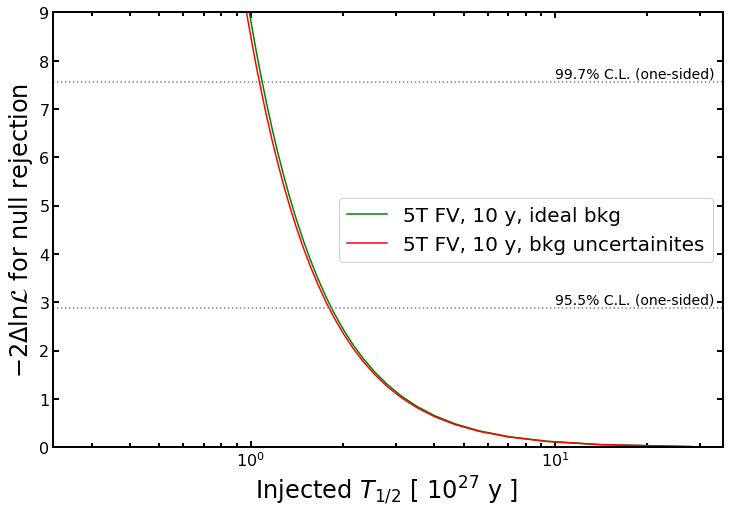

In [26]:
# And plotting the scan 
fig = plt.figure(figsize = (12,8))
ax= fig.add_subplot(111)


T_1_2 = 0.28157 / signal_strength

ax.plot(T_1_2, 2.0*(LLHs_null['ideal'] - LLHs_global['ideal']), c ="g", label = "5T FV, 10 y, ideal bkg" )
ax.plot(T_1_2, 2.0*(LLHs_null['real'] - LLHs_global['real']), c ="r" , label = "5T FV, 10 y, bkg uncertainites" )


#plt.axhline(1.0, c= "0.5", ls =":")
plt.axhline(7.55, c= "0.5", ls =":")
plt.axhline(2.874, c= "0.5", ls =":")
plt.text(10,7.65, "99.7% C.L. (one-sided)", fontsize=14)
plt.text(10,2.974, "95.5% C.L. (one-sided)", fontsize=14)

ax.set_ylim(0, 9)
ax.set_xscale("log")
#ax.set_xlim(0, 0.8)
ax.set_ylabel(r"$ - 2 \Delta \ln \mathcal{L} $ for null rejection")
ax.set_xlabel(r" Injected $T_{1/2}$ [ $10^{27}$ y ]  ")
ax.legend(fontsize=20)

#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_discovery_halflife_2200_2800.png", dpi=300)
#fig.savefig("/home/pat/terliuk/science/DARWIN/0vbb_sens/DARWIN_5t_10y_discovery_halflife_2200_2800.pdf", dpi=300)

In [27]:
from scipy.interpolate import interp1d
from scipy.optimize import root
discovery = {}
discovery_results = {}
for case in ['ideal', 'real']:
    # Creating spline 
    critical_value = 7.55 # This is critical value for xi^2 with 1 dof for 90% C.L. 
    doubleLLH_profile = interp1d(T_1_2[1:], 2.0 * (LLHs_null[case] - LLHs_global[case])[1:], kind="cubic") 
    halflife_result =  root(lambda x: doubleLLH_profile(x) - critical_value, 0.65 ) 
    #print(halflife_result)
    discovery_results[case]=halflife_result
    discovery[case]=halflife_result['x']

In [28]:
discovery

{'ideal': array([1.0896885]), 'real': array([1.06704794])}